<div align="right">  

    
    André Neves da Costa - A95869 
    Filipe José Silva Castro - A96156 
</div>

In [5]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute

from qiskit.tools.visualization import plot_histogram, plot_distribution

import matplotlib.pyplot as plt

import numpy as np

# Formulação de uma fórmula booleana 3-SAT solúvel

Para a formulação de uma fórmula booleana 3-SAT solúvel utilizamos a presente no enunciado e acrescentamos $\wedge (\neg v1 \vee v2 \vee \neg v3) \wedge (\neg v1 \vee \neg v2 \vee v3)$ de modo a obter uma fórmula com apenas uma solução.

Sendo portanto a nossa fórmula:

$$ (\neg v1 \vee \neg v2 \vee \neg v3) \wedge (v1 \vee \neg v2 \vee v3) \wedge (v1 \vee v2 \vee \neg v3) \wedge (v1 \vee \neg v2 \vee \neg v3) \wedge (\neg v1 \vee v2 \vee v3) \wedge (\neg v1 \vee v2 \vee \neg v3) \wedge (\neg v1 \vee \neg v2 \vee v3)$$

# Implementação do algoritmo de Grover

O método de implementação do algoritmo de grover consiste em:

* **Sobreposição uniforme** $\\$
      Sobreposição sobre elementos da base de dados;
* **Oráculo** $\\$
      Marcação o elemento que queremos encontrar;
* **Operador de difusão** $\\$
      Amplificação da amplitude.

## ```init```
Recebe como argumento a fórmula booleana e a partir desta vai inicializar o circuito, para tal vai criar:

* 3 Qubits representativos de v1, v2 e v3;

* 1 Qubit para cada bloco existente da fórmula booleana;

* 1 Qubit para o valor total da fórmula booleana para cada iteração.

Na inicialização vai ser então feita a **sobreposição uniforme**, aplicando o gate H aos bits de v1,v2 e v3 e aplicando o gate X seguido do H às ancillas.

Devolve os Quantum Circuits, o Quantum Register e o Classical Register criados.

In [6]:
def init(flips):

  qr = QuantumRegister(3, name = 'v')

  ancilla = QuantumRegister(len(flips) + 1, name = 'ancilla')

  cr = ClassicalRegister(3)

  qc = QuantumCircuit(qr, ancilla, cr)


  qc.h(qr)

  qc.x(ancilla)

  qc.h(ancilla)

  qc.barrier()
  
  
  return qc, qr, ancilla, cr

## ```oracle```
Como não é possível utilizar disjunção em qubits, a fórmula definida anteriormente foi transformada, onde apenas negamos todos os blocos que estavam separados por conjunções, obtendo o seguinte:


$$ \neg ( v1 \wedge v2 \wedge v3) \wedge \neg (\neg v1 \wedge v2 \wedge \neg v3) \wedge \neg (\neg v1 \wedge \neg v2 \wedge v3) \wedge \neg (\neg v1 \wedge v2 \wedge v3) \wedge $$
$$\neg ( v1 \wedge \neg v2 \wedge \neg v3) \wedge \neg (v1 \wedge \neg v2 \wedge v3) \wedge \neg (v1 \wedge v2 \wedge \neg v3)$$

O oracle então recebe um QuantumRegister, ancilla e flips.

A execução do oracle consiste na iteração dos blocos da fórmula boleana, aplicando o gate X aos qubits que serão negados, a gate MCX aos qubits v e novamente a gate X aos qubits onde esta foi aplicada anteriormente.

No final de todas as iterações é então aplicada a gate MCX a todas as ancillas que representam os blocos da fórmula boelana e tendo como target a ultima ancilla.

Devolve o QuantumCircuit onde são aplicadas as gates.

In [13]:
def oracle(qr, ancilla, flips):

    qc = QuantumCircuit(qr,ancilla)

    for k, flip in enumerate(flips):

        for i in range(3):

            if not flip[i]:

                qc.x(i)

        
        qc.mcx(qr, ancilla[k])


        qc.x(ancilla[k])


        for i in range(3):

            if not flip[i]:

                qc.x(i)


        qc.barrier()


    qc.mcx(ancilla[:-1],ancilla[-1])
    
    qc.barrier()
    
    return qc

## ```diffusion_operator```
Recebe como argumento QuantumRegister e ancilla.

É aplicado o operador de difusão a um QuantumCircuit.

Devolve o QuantumCircuit.

In [14]:
def diffusion_operator(qr, ancilla):


    qc = QuantumCircuit(qr,ancilla)


    qc.h(qr)

    qc.x(qr)

    qc.h(qr[-1])

    qc.mcx(qr[:-1],qr[-1])

    qc.h(qr[-1])

    qc.x(qr)

    qc.h(qr)


    qc.barrier()
    
    return qc 

## ```grover```

Recebe um QuantumCircuit, QuantumRegister, ancilla, oracle e flips.

Calcula o número de iterações que serão executadas e, para cada uma delas, executa o oracle e o diffusion_operator aplicando os seus resultados ao qc recebido.

Devolve o QuantumCircuit.

### Calcular o número de iterações
Para calcular o número ótimo de iterações, é usada a fórmula $(\pi / 4) \sqrt N$, sendo N = 2^3 (número de combinações possíveis com os 3 qubits v).
Esta fórmula vai nos dar o número de iterações ideal para as probabilidades terem a maior precisão possível.

Como o número de iterações será igual a $(\pi / 4) \sqrt N$ então o algoritmo de grover tem complexidade $O(\sqrt N)$.

In [15]:
def grover(qc,qr,ancilla,oracle,flips):

  iterations=int(np.floor(np.pi/4 * np.sqrt(2 ** 3)))


  for j in range(iterations):

    qc = qc.compose(oracle(qr,ancilla,flips))

    qc = qc.compose(diffusion_operator(qr,ancilla))
    

  return qc

Sejam os flips a tradução da nossa fórmula booleana que o grover vai usar, fazemos a sua inicialização, aplicamos o algoritmo de grover, medimos os resultados e desenhamos o QuantumCircuit, obtendo então:

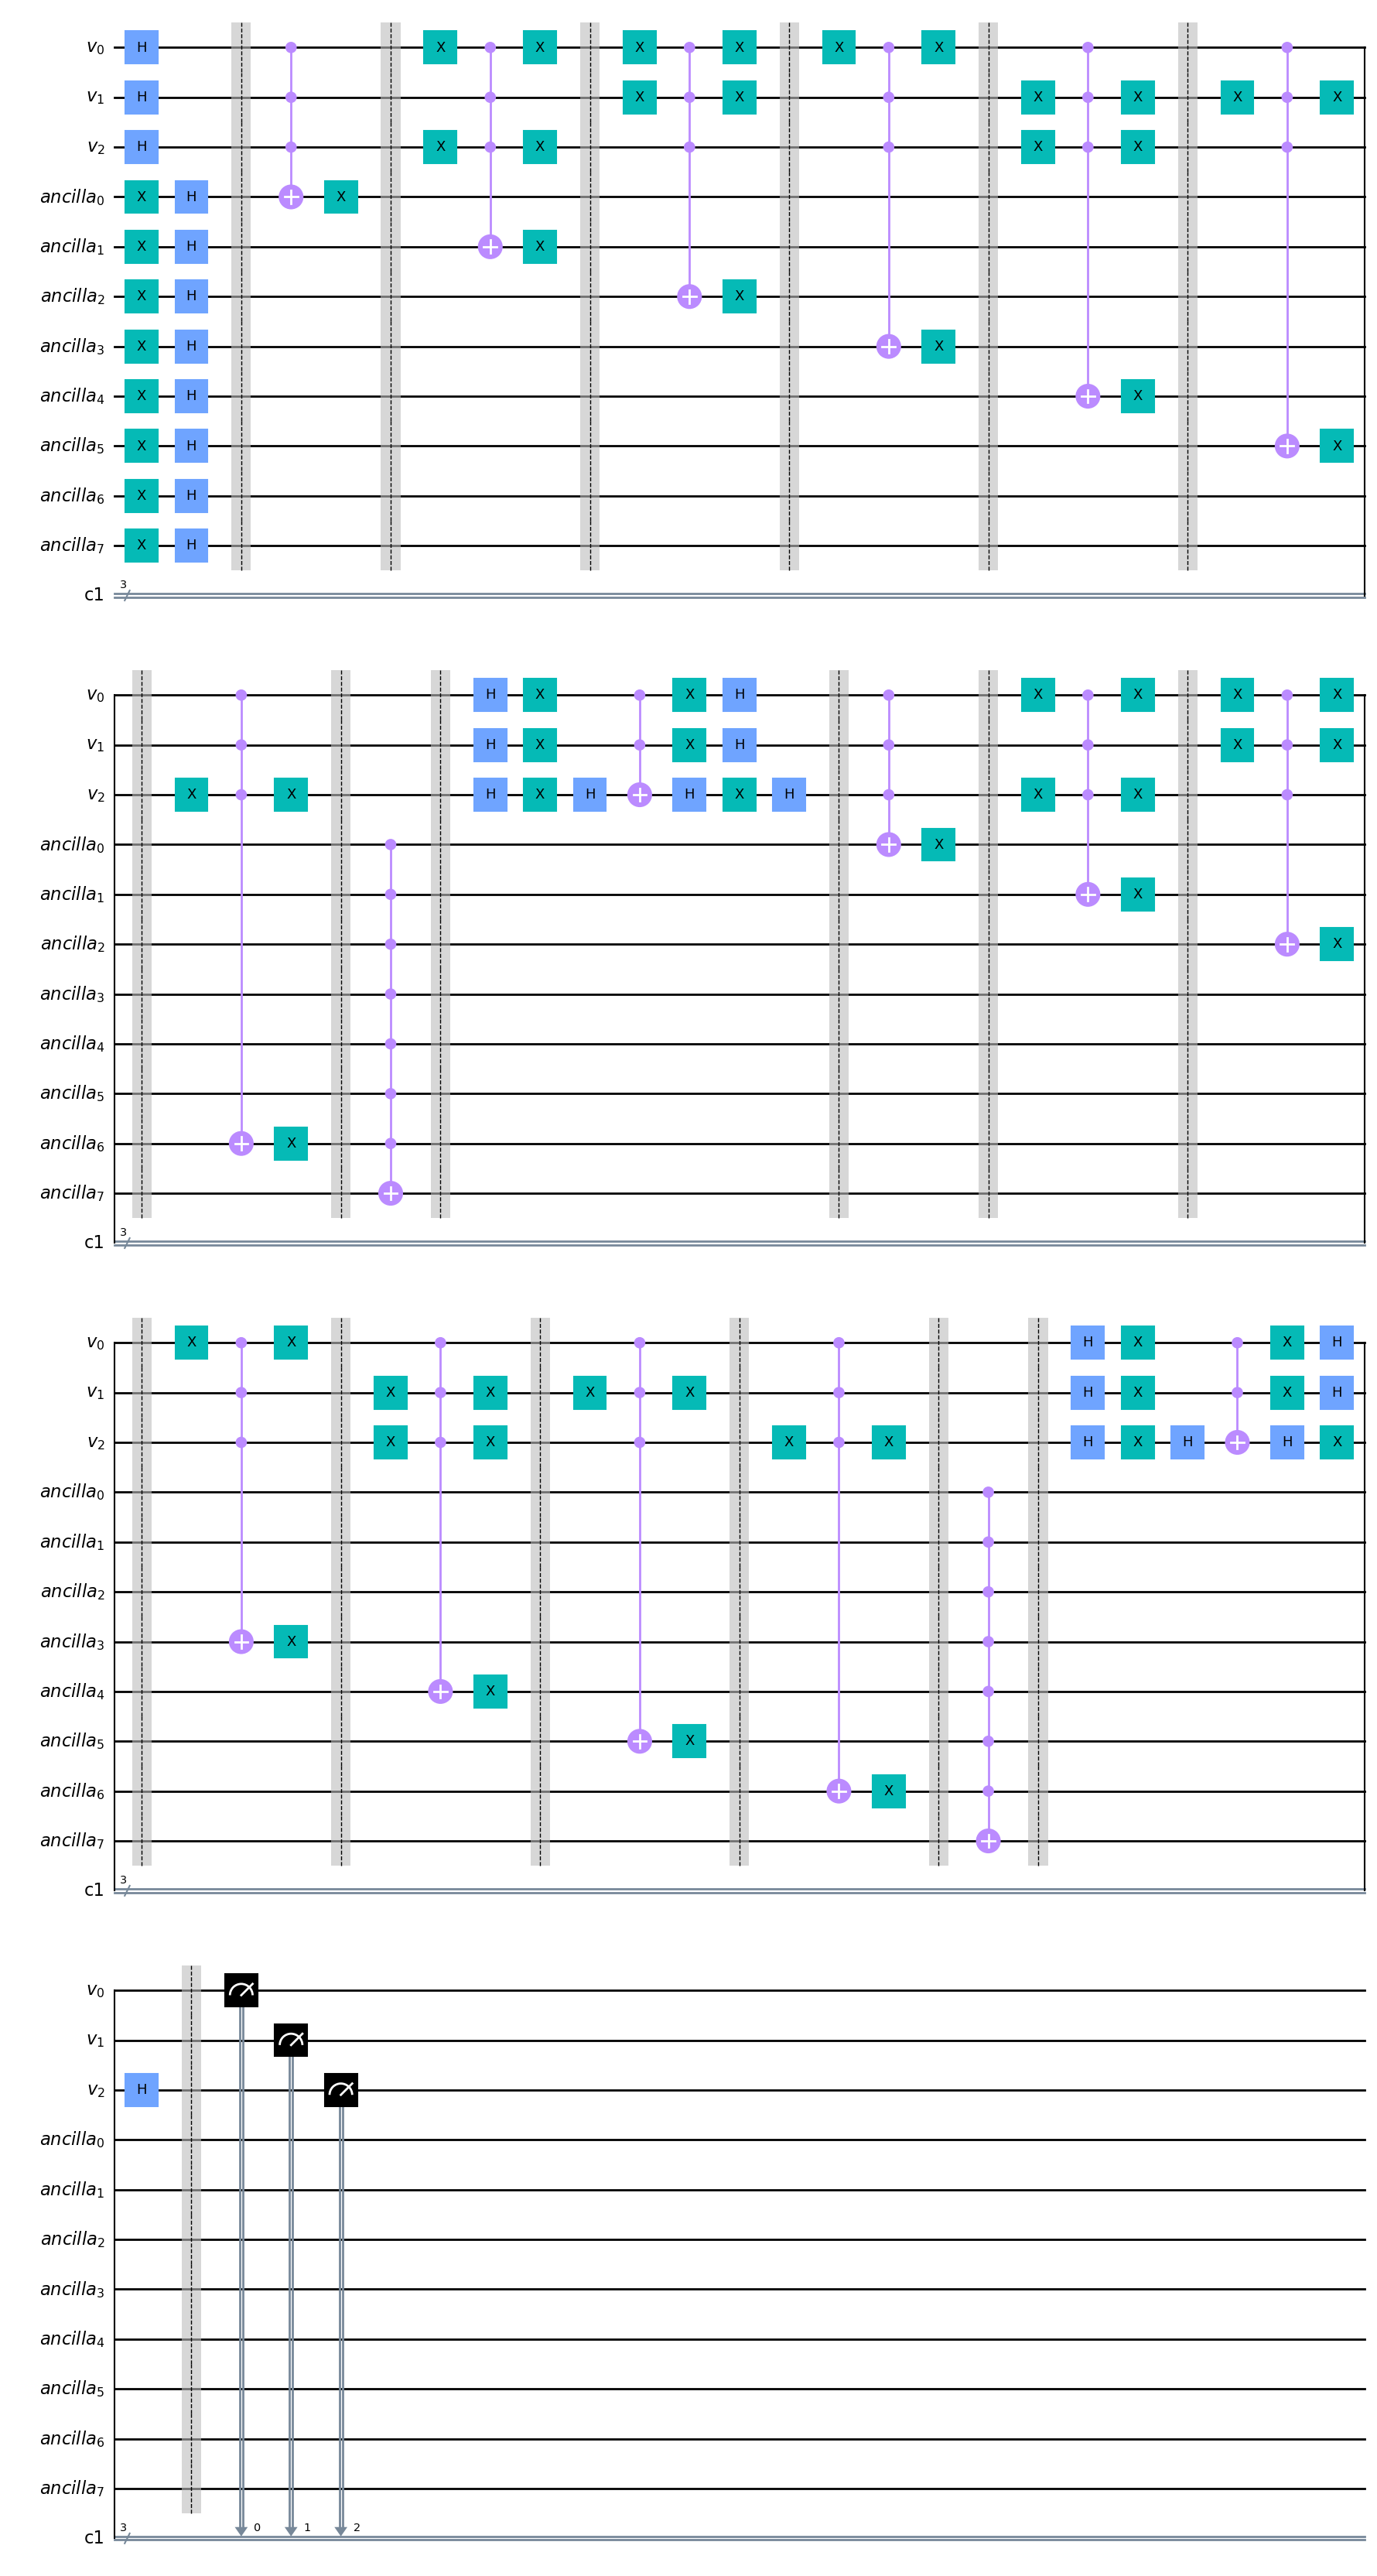

In [16]:
flips = [[True,True,True],
         [False,True,False],
         [False,False,True],
         [False,True,True],
         [True,False,False],
         [True,False,True],
         [True,True,False]]

qc,qr,ancilla,cr = init(flips)

qc = grover(qc,qr,ancilla,oracle,flips)

qc.measure(qr,cr)

qc.draw(output = "mpl")

## ```execute_circuit```

Recebe um QuantumCircuit e executa-o.

Devolve o número de vezes que obtêm cada resultado.

In [17]:
def execute_circuit(qc, shots=1024, decimal=False):
    
    device = Aer.get_backend('qasm_simulator')

    counts = execute(qc, device, shots=shots).result().get_counts()
    

    if decimal:

        counts = dict((int(a[::-1],2),b/1024) for (a,b) in counts.items())

    else:

        counts = dict((a[::-1],b/1024) for (a,b) in counts.items())
        
    
    return counts

## Resultados

É então executado o QuantumCircuit e o seu resultado apresentado a partir de um histograma.

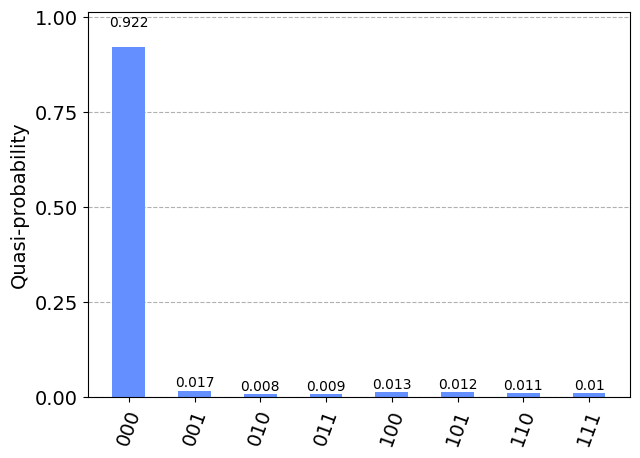

In [18]:
plot_histogram(execute_circuit(qc,1024))

Substituindo na fórmula booleana que formulamos anteriormente os valores de v1, v2 e v3 por 0, verificamos que dá o resultado correto e então, concluimos que há a probabilidade de 93,3% de obtermos o resultado correto.